In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import StructType, StructField, TimestampType
from pyspark.ml.feature import StringIndexer
import numpy as np

spark = SparkSession.builder.appName("NYC311Calls").getOrCreate()


### Data Descriptions

#### Read Data

In [ ]:
uri = "enter your path"

data = spark.read.csv(
    uri,
    header=True,
    inferSchema=True
)

#### Data Samples

In [ ]:
data.show(5)

+----------+--------------------+-----------+------+--------------------+-----------------+-----------------+-------------+------------+--------------------+------------------+--------------------+------------------+---------------------+---------------------+------------+-------------------+--------+-------------+------+--------+----------------------+------------------------------+---------------+----------+--------+--------------------------+--------------------------+----------------------+------------------+------------+------------+--------------------+---------------------+-------------------+------------------------+---------+----------------------+-----------------+------------------+--------------------+---------+-------------------+------------------+----------------------+----------------+---------------+
|Unique Key|        Created Date|Closed Date|Agency|         Agency Name|   Complaint Type|       Descriptor|Location Type|Incident Zip|    Incident Address|       Street 

#### Data Schema

In [ ]:
data.printSchema()

root
 |-- Unique Key: integer (nullable = true)
 |-- Created Date: string (nullable = true)
 |-- Closed Date: string (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Agency Name: string (nullable = true)
 |-- Complaint Type: string (nullable = true)
 |-- Descriptor: string (nullable = true)
 |-- Location Type: string (nullable = true)
 |-- Incident Zip: string (nullable = true)
 |-- Incident Address: string (nullable = true)
 |-- Street Name: string (nullable = true)
 |-- Cross Street 1: string (nullable = true)
 |-- Cross Street 2: string (nullable = true)
 |-- Intersection Street 1: string (nullable = true)
 |-- Intersection Street 2: string (nullable = true)
 |-- Address Type: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Landmark: string (nullable = true)
 |-- Facility Type: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Due Date: string (nullable = true)
 |-- Resolution Description: string (nullable = true)
 |-- Resolution Actio

#### Data Size

In [ ]:
data.count()

9374581

#### Nulls Count

In [ ]:
null_counts = data.select([F.count(F.when(F.col(c).isNull(),c)).alias(c) for c in data.columns]).collect()[0]

null_counts_dict = null_counts.asDict()

print("Null Counts in Each Column:")
for column, count in null_counts_dict.items():
    print(f"{column}: {count}")

Null Counts in Each Column:
Unique Key: 0
Created Date: 0
Closed Date: 367452
Agency: 0
Agency Name: 0
Complaint Type: 0
Descriptor: 105525
Location Type: 1207787
Incident Zip: 157722
Incident Address: 429011
Street Name: 429328
Cross Street 1: 2586873
Cross Street 2: 2587377
Intersection Street 1: 3395188
Intersection Street 2: 3390668
Address Type: 1183637
City: 508123
Landmark: 4113063
Facility Type: 8687500
Status: 0
Due Date: 9347266
Resolution Description: 427235
Resolution Action Updated Date: 141129
Community Board: 7608
BBL: 1125785
Borough: 7608
X Coordinate (State Plane): 168585
Y Coordinate (State Plane): 167463
Open Data Channel Type: 0
Park Facility Name: 0
Park Borough: 7608
Vehicle Type: 9365786
Taxi Company Borough: 9369615
Taxi Pick Up Location: 9292550
Bridge Highway Name: 9296372
Bridge Highway Direction: 9335351
Road Ramp: 9352663
Bridge Highway Segment: 9296370
Latitude: 168699
Longitude: 168699
Location: 168699
Zip Codes: 201102
Community Districts: 171525
Boroug

### Data Preprocessing

#### Fix Column Names

In [ ]:
data = data.toDF(*[col.lower().replace(' ', '_') for col in data.columns])
print(data.columns)

['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name', 'complaint_type', 'descriptor', 'location_type', 'incident_zip', 'incident_address', 'street_name', 'cross_street_1', 'cross_street_2', 'intersection_street_1', 'intersection_street_2', 'address_type', 'city', 'landmark', 'facility_type', 'status', 'due_date', 'resolution_description', 'resolution_action_updated_date', 'community_board', 'bbl', 'borough', 'x_coordinate_(state_plane)', 'y_coordinate_(state_plane)', 'open_data_channel_type', 'park_facility_name', 'park_borough', 'vehicle_type', 'taxi_company_borough', 'taxi_pick_up_location', 'bridge_highway_name', 'bridge_highway_direction', 'road_ramp', 'bridge_highway_segment', 'latitude', 'longitude', 'location', 'zip_codes', 'community_districts', 'borough_boundaries', 'city_council_districts', 'police_precincts', 'police_precinct']


#### Keep Useful Columns

In [ ]:
keeps = ['created_date', 'closed_date', 'agency', 'complaint_type', 'location_type', 'incident_zip', 'address_type', 'city', 'status', 'borough', 'open_data_channel_type', 'x_coordinate_(state_plane)', 'y_coordinate_(state_plane)', 'latitude', 'longitude']

data = data.select(*keeps)
print(data.columns)

['created_date', 'closed_date', 'agency', 'complaint_type', 'location_type', 'incident_zip', 'address_type', 'city', 'status', 'borough', 'open_data_channel_type', 'x_coordinate_(state_plane)', 'y_coordinate_(state_plane)', 'latitude', 'longitude']


#### Keep Only Closed 311 Calls

In [ ]:
data = data.where(F.lower(F.col("status")) == "closed").drop("status")

#### Drop Null Rows

In [ ]:
data = data.dropna()
print(data.count())

6415585


#### Fix Data Types (DateTime)

In [ ]:
dateFormat = "MM/dd/yyyy hh:mm:ss a"

data = (data.withColumn("created_date", F.to_timestamp(F.col("created_date"), dateFormat))
            .withColumn("closed_date", F.to_timestamp(F.col("closed_date"), dateFormat)))

data.printSchema()

root
 |-- created_date: timestamp (nullable = true)
 |-- closed_date: timestamp (nullable = true)
 |-- agency: string (nullable = true)
 |-- complaint_type: string (nullable = true)
 |-- location_type: string (nullable = true)
 |-- incident_zip: string (nullable = true)
 |-- address_type: string (nullable = true)
 |-- city: string (nullable = true)
 |-- borough: string (nullable = true)
 |-- open_data_channel_type: string (nullable = true)
 |-- x_coordinate_(state_plane): integer (nullable = true)
 |-- y_coordinate_(state_plane): integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)



#### Remove Created Date > Closed Date

In [ ]:
data = data.where(F.col("created_date") < F.col("closed_date"))

### Feature Engineering

#### Add Resolution Time (Minutes)

In [ ]:
data = data.withColumn("resolution_time", F.ceil((F.unix_timestamp("closed_date") - F.unix_timestamp("created_date")) / 60))
data.select("resolution_time").show()

+---------------+
|resolution_time|
+---------------+
|              3|
|              5|
|              4|
|              6|
|              9|
|             23|
|             26|
|              2|
|             11|
|             11|
|             16|
|             23|
|              2|
|             32|
|             19|
|             22|
|             27|
|              7|
|             23|
|             34|
+---------------+
only showing top 20 rows



#### Turn Created Dates into Day and Time

In [ ]:
data = (data.withColumn("created_day_of_week", F.dayofweek("created_date"))
            .withColumn("created_hour_of_day", F.hour("created_date")))

data = data.drop("created_date", "closed_date")


In [ ]:
data.printSchema()

root
 |-- agency: string (nullable = true)
 |-- complaint_type: string (nullable = true)
 |-- location_type: string (nullable = true)
 |-- incident_zip: string (nullable = true)
 |-- address_type: string (nullable = true)
 |-- city: string (nullable = true)
 |-- borough: string (nullable = true)
 |-- open_data_channel_type: string (nullable = true)
 |-- x_coordinate_(state_plane): integer (nullable = true)
 |-- y_coordinate_(state_plane): integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- resolution_time: long (nullable = true)
 |-- created_day_of_week: integer (nullable = true)
 |-- created_hour_of_day: integer (nullable = true)



#### Reduce the number of Complaint Types

In [ ]:
threshold = 5000

ct_counts = data.groupBy("complaint_type").count()
ct_counts_5000 = ct_counts.filter(F.col("count") >= threshold)
keep_ct_list = [row['complaint_type'] for row in ct_counts_5000.select("complaint_type").collect()]

In [ ]:
data = data.withColumn(
    "complaint_type",
    F.when(F.col("complaint_type").isin(keep_ct_list), F.col("complaint_type"))
    .otherwise("others")
)

In [ ]:
data.select("complaint_type").distinct().count()

76

### EDA

In [ ]:
import matplotlib.pyplot as plt

def plot_dist(data, x, y, xlabel, ylabel, title, top_n=100, asc=False):
    data = data.sort_values(by=y, ascending=asc).head(top_n)
    data.plot(kind='bar', x=x, y=y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

#### 311 Calls Agency Distribution

In [ ]:
agencies = data.groupBy("agency").count().toPandas()

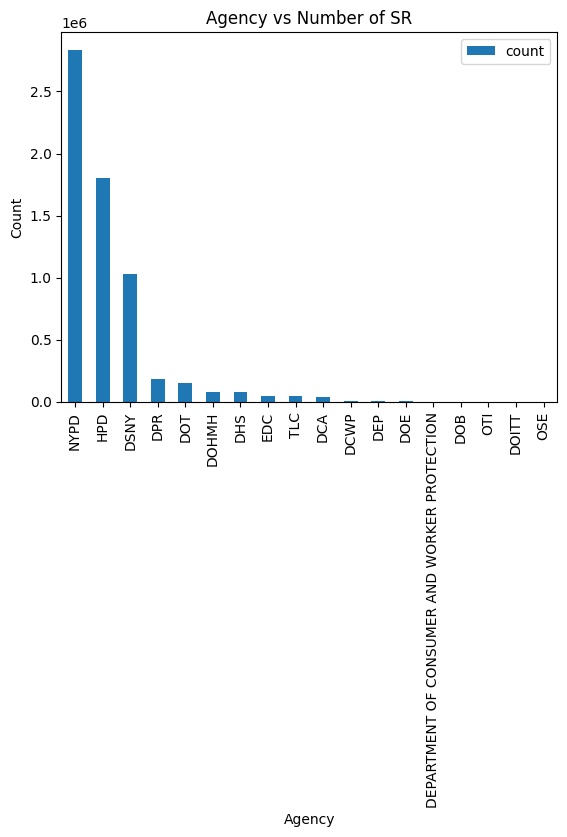

In [ ]:
plot_dist(agencies, 'agency', 'count', 'Agency','Count', 'Agency vs Number of SR')

#### Compaints vs. Borough

In [ ]:
boroughs = data.groupBy("borough").count().toPandas()

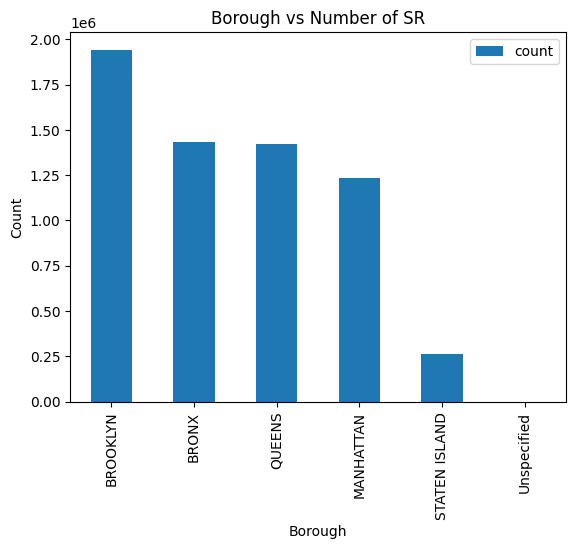

In [ ]:
plot_dist(boroughs, "borough", 'count', "Borough",'Count', 'Borough vs Number of SR')

#### Complaint Types

In [ ]:
complaints = data.groupBy("complaint_type").count().toPandas()

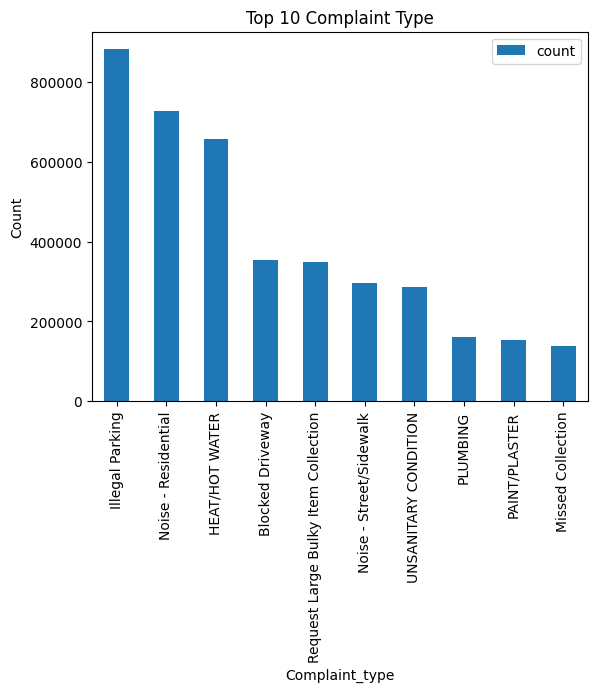

In [ ]:
plot_dist(complaints, "complaint_type", 'count', "Complaint_type",'Count', 'Top 10 Complaint Type', 10)

#### Agency vs. Average Resolution Time

In [ ]:
resolution_time_agency = (data.groupBy("agency")
    .agg(
        F.avg("resolution_time").alias("avg_resolution_time"),
    ).toPandas())

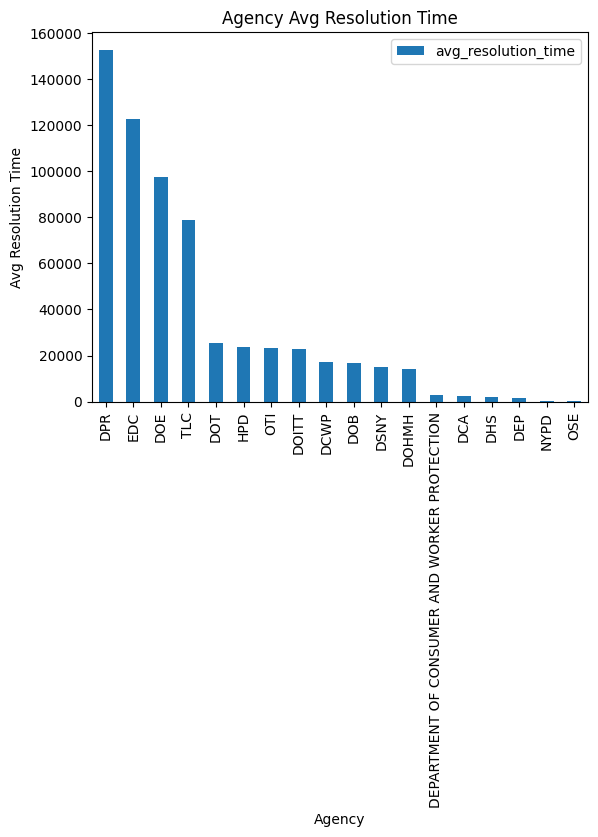

In [ ]:
plot_dist(resolution_time_agency, "agency", 'avg_resolution_time', "Agency", 'Avg Resolution Time', 'Agency Avg Resolution Time')

#### Borough vs. Average Resolution Time

In [ ]:
resolution_time_borough = (data.groupBy("borough")
    .agg(
        F.avg("resolution_time").alias("avg_resolution_time"),
    ).toPandas())

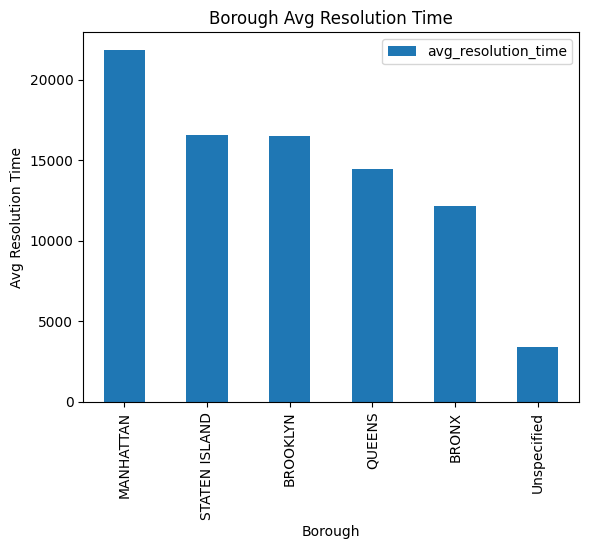

In [ ]:
plot_dist(resolution_time_borough, "borough", 'avg_resolution_time', "Borough", 'Avg Resolution Time', 'Borough Avg Resolution Time')

#### Complaint Type vs. Average Resolution Time

In [ ]:
resolution_time_complaints = (data.groupBy("complaint_type")
    .agg(
        F.avg("resolution_time").alias("avg_resolution_time"),
    ).toPandas())

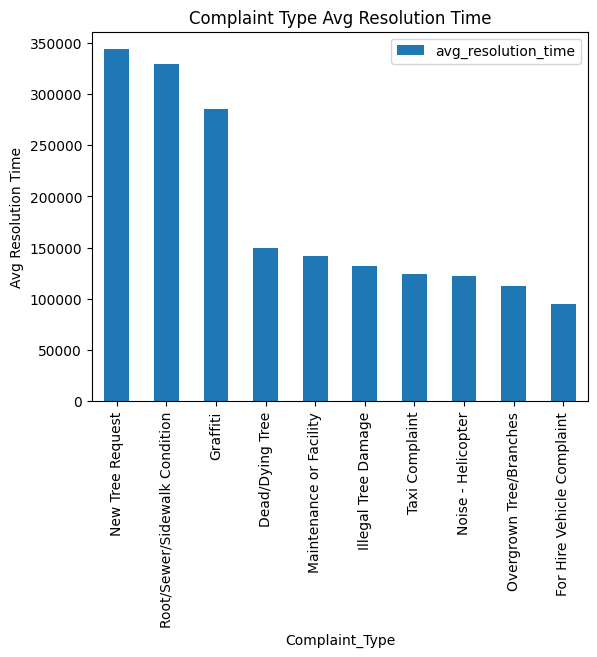

In [ ]:
plot_dist(resolution_time_complaints, "complaint_type", 'avg_resolution_time', "Complaint_Type", 'Avg Resolution Time', 'Complaint Type Avg Resolution Time', 10)

### Main Data Preprocessing

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, replace, count, when, isnan, isnull, to_timestamp, unix_timestamp, countDistinct
from pyspark.sql.types import StructType, StructField, TimestampType
from pyspark.ml.feature import StringIndexer

spark = SparkSession.builder.appName("NYC311Calls").getOrCreate()

spark.conf.set("spark.sql.sources.commitProtocolClass", "org.apache.spark.sql.execution.datasources.SQLHadoopMapReduceCommitProtocol")
spark.conf.set("parquet.enable.summary-metadata", "false")
spark.conf.set("mapreduce.fileoutputcommitter.marksuccessfuljobs", "false")

In [ ]:
uri = "enter your path"

data = spark.read.csv(
    uri,
    header=True,
    inferSchema=True
)

#### All Data Transformations

In [ ]:
dateFormat = "MM/dd/yyyy hh:mm:ss a"

threshold = 5000

ct_counts = data.groupBy("Complaint Type").count()
ct_counts_thresh = ct_counts.filter(F.col("count") >= threshold)
keep_ct_list = [row["Complaint Type"] for row in ct_counts_thresh.select("Complaint Type").collect()]

In [ ]:
keeps = ['created_date', 'closed_date', 'agency', 'complaint_type', 'status', 'borough', 'open_data_channel_type', 'latitude', 'longitude']

data = (data.toDF(*[col.lower().replace(' ', '_') for col in data.columns])
        .select(*keeps)
        .where(F.lower(F.col("status")) == "closed")
        .drop("status")
        .dropna()
        .withColumn("created_date", F.to_timestamp(F.col("created_date"), dateFormat))
        .withColumn("closed_date", F.to_timestamp(F.col("closed_date"), dateFormat))
        .where(F.col("created_date") < F.col("closed_date"))
        .withColumn("resolution_time", F.ceil((F.unix_timestamp("closed_date") - F.unix_timestamp("created_date")) / 60))
        .withColumn("created_day_of_week", F.dayofweek("created_date"))
        .withColumn("created_hour_of_day", F.hour("created_date"))
        .drop("created_date", "closed_date")
        .withColumn("complaint_type", 
                    F.when(F.col("complaint_type").isin(keep_ct_list), F.col("complaint_type"))
                    .otherwise("others")))

data.printSchema()

root
 |-- agency: string (nullable = true)
 |-- complaint_type: string (nullable = true)
 |-- borough: string (nullable = true)
 |-- open_data_channel_type: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- resolution_time: long (nullable = true)
 |-- created_day_of_week: integer (nullable = true)
 |-- created_hour_of_day: integer (nullable = true)



#### Save Preprocessed Data for ML use

In [ ]:
save_uri = "enter your path"
data.coalesce(1).write.csv(save_uri, header=True)